In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly_express as px
import pandas_profiling

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#this allows us to see all of our columns or rows in jupyter notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#filter future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#set our code up so that it doesn't display scientific notation, we want full numbers
pd.set_option('display.float_format', '{:.2f}'.format)

In [373]:
#load our data in
train = pd.read_csv('train.csv')
labels = pd.read_csv('labels.csv')
test = pd.read_csv('test.csv')
data = pd.merge(train, labels)
#create distinguising flags for test and train set
test['testflag'] = 1
#concatenate train and test data
data = pd.concat([data, test])

#move our labels to the end of the new dataset
data = data[[col for col in data.columns if col != 'poverty_probability' ] + ['poverty_probability']]

#check out the head of the data
data.head()

,active_bank_user,active_formal_nbfi_user,active_informal_nbfi_user,active_mm_user,advanced_phone_use,age,avg_shock_strength_last_year,bank_interest_rate,borrowed_for_daily_expenses_last_year,borrowed_for_emergency_last_year,borrowed_for_home_or_biz_last_year,borrowing_recency,can_add,can_calc_compounding,can_calc_percents,can_call,can_divide,can_make_transaction,can_text,can_use_internet,cash_property_savings,country,education_level,employed_last_year,employment_category_last_year,employment_type_last_year,female,financially_included,formal_savings,has_insurance,has_investment,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,informal_savings,is_urban,literacy,married,mfi_interest_rate,mm_interest_rate,nonreg_active_mm_user,num_financial_activities_last_year,num_formal_institutions_last_year,num_informal_institutions_last_year,num_shocks_last_year,num_times_borrowed_last_year,other_fsp_interest_rate,phone_ownership,phone_technology,reg_bank_acct,reg_formal_nbfi_account,reg_mm_acct,relationship_to_hh_head,religion,row_id,share_hh_income_provided,testflag,poverty_probability
0,True,False,False,False,False,18,0.00,nan,False,False,False,0,True,True,True,True,True,False,True,False,False,C,1.00,False,housewife_or_student,not_working,True,True,False,False,False,False,False,False,False,False,False,False,False,True,True,nan,nan,False,1,1,0,0,0,nan,1,0,True,False,False,Other,P,0,1.00,nan,0.52
1,True,False,False,False,False,30,0.00,nan,False,False,False,0,True,False,False,True,True,False,False,False,False,C,1.00,False,housewife_or_student,not_working,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,nan,nan,False,0,1,0,0,0,nan,2,1,True,False,False,Other,P,1,nan,nan,0.98
2,False,False,False,False,False,20,0.00,nan,False,False,False,2,True,False,True,True,True,False,False,False,False,A,1.00,True,employed,irregular_seasonal,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,nan,nan,False,0,0,0,0,1,nan,2,1,False,False,False,Spouse,Q,2,1.00,nan,0.98
3,False,False,False,False,False,61,0.00,nan,False,False,False,0,True,True,False,True,True,False,False,False,False,A,0.00,True,employed,self_employed,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,nan,nan,False,0,0,0,0,0,nan,0,0,False,False,False,Head,Q,3,nan,nan,0.88
4,False,False,False,False,False,26,0.00,nan,False,False,False,0,False,False,False,True,True,True,True,False,True,D,1.00,False,housewife_or_student,not_working,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,nan,nan,False,3,1,0,0,0,nan,1,0,False,False,False,Spouse,X,4,2.00,nan,0.80


In [169]:
# Printing the percentage of missing values per column
def percent_missing(dataframe):
    '''
    Prints the percentage of missing values for each column in a dataframe
    '''
    # Summing the number of missing values per column and then dividing by the total
    sumMissing = dataframe.isnull().values.sum(axis=0)
    pctMissing = sumMissing / dataframe.shape[0]
    
    if sumMissing.sum() == 0:
        print('No missing values')
    else:
        # Looping through and printing out each columns missing value percentage
        print('Percent Missing Values:', '\n')
        for idx, col in enumerate(dataframe.columns):
            if sumMissing[idx] > 0:
                print('{0}: {1:.2f}%'.format(col, pctMissing[idx] * 100))

__Using Pandas Profiling to create descriptive report__

In [6]:
profile = data.profile_report()
profile.get_rejected_variables(threshold=0.9)  # Rejected variables w/ high correlation
profile

['row_id']

# Let's fill in the missing values 
- we are going to try both removing and imputing 0s for bank_interest_rate becuase it is missing almost all of its values
- we are going to try and fill in education_level with a median encoded value
- we are going to try both dropping and imputing 0s for mfi_interest_rate becuase it is missing almost all of its values
- we are going to try dropping and imputing 0s for mm_interest_rate because it is missing almost all of its values
- we are going to try dropping and imputing 0s for other_fsp_interest_rate becuase it is missing almost all of its values
- we are going to impute for the missing values in share_hh_income_provided

In [374]:
#----------tried dropping them and imputing, don't see much of a difference
# unlucky_columns = ['bank_interest_rate', 'mfi_interest_rate', 'mm_interest_rate', 'other_fsp_interest_rate']
# data.drop(unlucky_columns, axis=1, inplace=True)
data['bank_interest_rate'].fillna(0, inplace = True)
data['mfi_interest_rate'].fillna(0, inplace = True)
data['mm_interest_rate'].fillna(0, inplace = True)
data['other_fsp_interest_rate'].fillna(0, inplace = True)

In [375]:
percent_missing(data)

Percent Missing Values: 

education_level: 1.83%
share_hh_income_provided: 2.37%
testflag: 60.00%
poverty_probability: 40.00%


__Now lets explore education_level__
- education_level - Highest level of education (0=no education, 1=primary education, 2=secondary education, 3=higher education)

Education level is correlated pretty well with literacy (.59), so I am going to try to fill in these cases based on literacy

In [376]:
data['education_level'] = data.groupby('literacy').education_level.transform(lambda x: x.replace(np.nan, x.median()))

In [377]:
data.groupby('literacy').education_level.mean()

literacy
False   0.65
True    1.74
Name: education_level, dtype: float64

I think that this is ok, but should check to see if we need to make these values whole numbers or not?

In [378]:
data['education_level'].unique()

array([1., 0., 2., 3.])

In [379]:
percent_missing(data)

Percent Missing Values: 

share_hh_income_provided: 2.37%
testflag: 60.00%
poverty_probability: 40.00%


__Now I want to look at share_hh_income_provided__
-  Share of household income provided

In [380]:
data['share_hh_income_provided'].unique()

array([ 1., nan,  2.,  5.,  3.,  4.])

This feature is correlated (.46) with employed_last_year, so lets impute based on the mean of that

In [381]:
data['share_hh_income_provided'] = data.groupby('employed_last_year').share_hh_income_provided.transform(lambda x: x.replace(np.nan, x.median()))

In [382]:
percent_missing(data)

Percent Missing Values: 

testflag: 60.00%
poverty_probability: 40.00%


# Data Visulization
- Here I want to discover relationship between variables in the data and poverty_probability

__Plot poverty_probability by country and gender__

country
A   0.75
C   0.61
D   0.78
F   0.51
G   0.55
I   0.53
J   0.55
Name: poverty_probability, dtype: float64

<Figure size 1440x720 with 0 Axes>

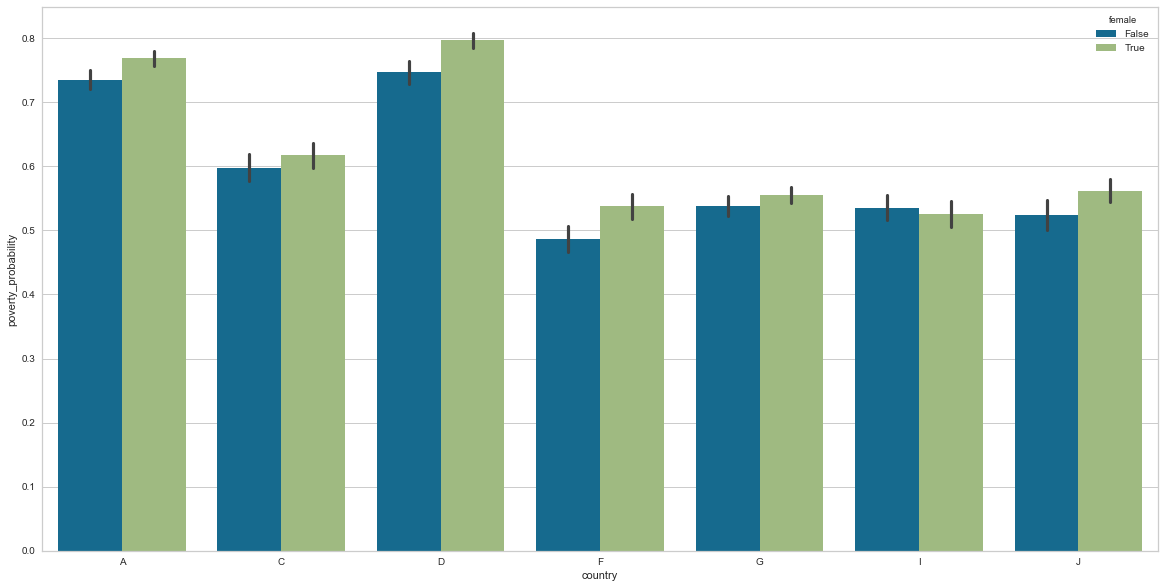

In [262]:
data.groupby('country').poverty_probability.mean()
#plot countries in sorted order
plt.figure(figsize=(20, 10))
sns.barplot(data = data.sort_values(by = ['country']), x = 'country', y = 'poverty_probability', hue = 'female')

__No strong relationship between age and poverty__

<Figure size 2160x1440 with 0 Axes>

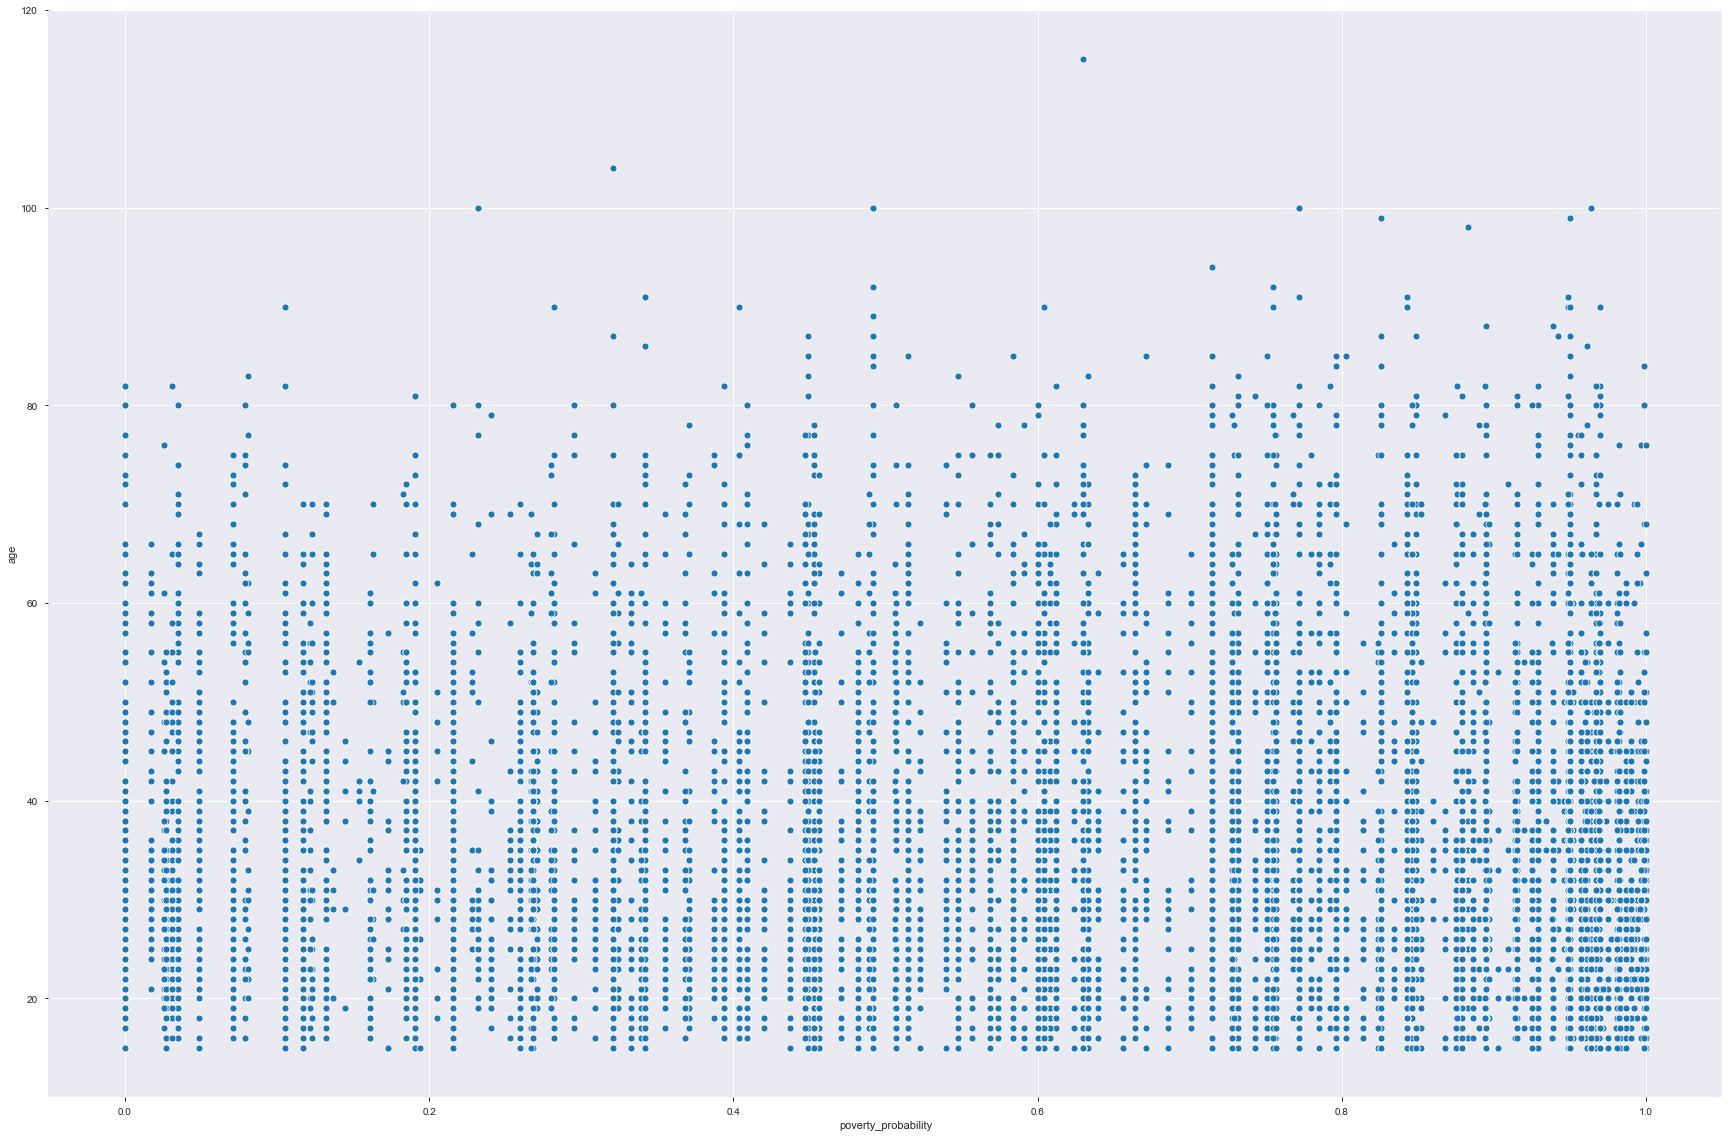

In [208]:
plt.figure(figsize=(30, 20))
sns.scatterplot(data = data, x = 'poverty_probability', y = 'age')

__Comparing men and women in poverty by education level__

female  education_level
False   0.00              0.71
        1.00              0.68
        2.00              0.53
        3.00              0.40
True    0.00              0.71
        1.00              0.70
        2.00              0.52
        3.00              0.38
Name: poverty_probability, dtype: float64

<Figure size 1440x720 with 0 Axes>

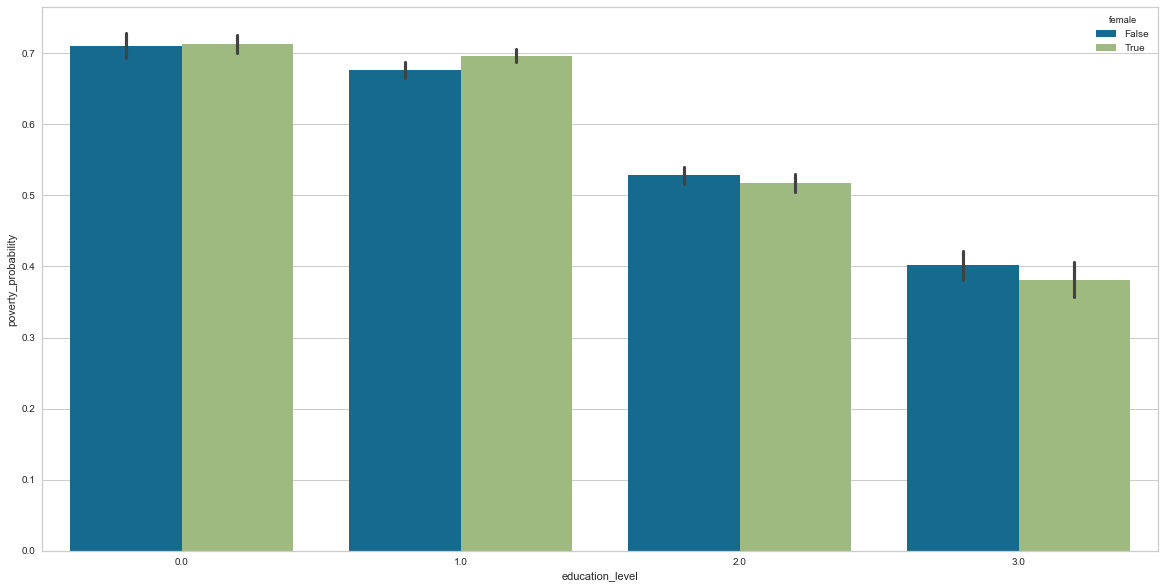

In [196]:
data.groupby(['female', 'education_level']).poverty_probability.mean()
plt.figure(figsize=(20, 10))
sns.barplot(data = data, x = 'education_level', y = 'poverty_probability', hue = 'female')

In [35]:
poverty_data = data[data['poverty_probability'] > .5]

In [40]:
poverty_data.groupby('country').poverty_probability.mean()

country
A   0.80
C   0.82
D   0.84
F   0.81
G   0.71
I   0.77
J   0.80
Name: poverty_probability, dtype: float64

# Outlier Detection
- I am going to begin by looking at the age outliers and removing any high ages

In [179]:
def boxplot(X):
    plt.figure(figsize = (10, 5))
    sns.boxplot(X)
    return sns.boxplot(X)

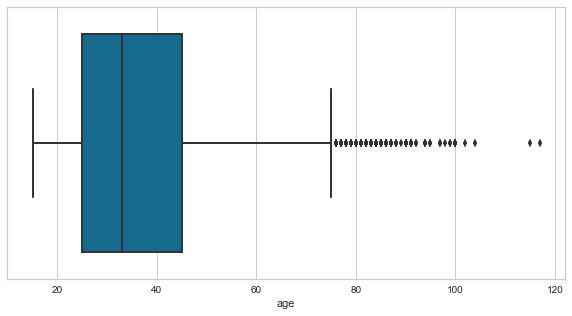

In [180]:
boxplot(data['age'])

In [181]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(data['age']))
print(z)

[1.20757752 0.41870196 1.07609826 ... 1.01035863 0.2872227  0.68166048]


In [182]:
age_outliers = np.where(z > 3)

In [183]:
age_outliers

(array([  197,   372,   466,   830,   854,   878,  1238,  1355,  1504,
         1672,  1768,  1989,  2300,  2402,  3309,  3695,  3983,  4187,
         4212,  4335,  4920,  5546,  5940,  6368,  6428,  6745,  7517,
         7758,  8057,  8236,  8247,  8258,  8276,  8318,  8594,  8706,
         9026,  9055,  9115,  9329,  9334,  9598,  9724,  9828,  9869,
        10021, 10158, 10342, 10527, 10566, 10569, 10596, 10799, 10830,
        11055, 11294, 11757, 12040, 12596, 12627, 12716, 13101, 13562,
        13982, 14204, 14389, 14656, 14681, 14748, 14891, 15141, 15189,
        15241, 15506, 16129, 16132, 16458, 16535, 16560, 16935, 16977,
        17070, 17115, 17372, 17572, 17687, 18093, 18101, 18138, 19028,
        19180, 19192, 19195, 19307, 19335, 19415, 19685, 19715, 19814,
        20024, 20080, 20260, 20370, 20378, 20423, 20450, 20697, 20791],
       dtype=int64),)

In [184]:
# data.drop(data.index[[197,   372,   466,   830,   854,   878,  1238,  1355,  1504,
#          1672,  1768,  1989,  2300,  2402,  3309,  3695,  3983,  4187,
#          4212,  4335,  4920,  5546,  5940,  6368,  6428,  6745,  7517,
#          7758,  8057,  8236,  8247,  8258,  8276,  8318,  8594,  8706,
#          9026,  9055,  9115,  9329,  9334,  9598,  9724,  9828,  9869,
#         10021, 10158, 10342, 10527, 10566, 10569, 10596, 10799, 10830,
#         11055, 11294, 11757, 12040, 12596, 12627, 12716, 13101, 13562,
#         13982, 14204, 14389, 14656, 14681, 14748, 14891, 15141, 15189,
#         15241, 15506, 16129, 16132, 16458, 16535, 16560, 16935, 16977,
#         17070, 17115, 17372, 17572, 17687, 18093, 18101, 18138, 19028,
#         19180, 19192, 19195, 19307, 19335, 19415, 19685, 19715, 19814,
#         20024, 20080, 20260, 20370, 20378, 20423, 20450, 20697, 20791]], inplace = True)

In [185]:
data[data['age'] > 100]

,active_bank_user,active_formal_nbfi_user,active_informal_nbfi_user,active_mm_user,advanced_phone_use,age,avg_shock_strength_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_emergency_last_year,borrowed_for_home_or_biz_last_year,borrowing_recency,can_add,can_calc_compounding,can_calc_percents,can_call,can_divide,can_make_transaction,can_text,can_use_internet,cash_property_savings,country,education_level,employed_last_year,employment_category_last_year,employment_type_last_year,female,financially_included,formal_savings,has_insurance,has_investment,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,informal_savings,is_urban,literacy,married,nonreg_active_mm_user,num_financial_activities_last_year,num_formal_institutions_last_year,num_informal_institutions_last_year,num_shocks_last_year,num_times_borrowed_last_year,phone_ownership,phone_technology,reg_bank_acct,reg_formal_nbfi_account,reg_mm_acct,relationship_to_hh_head,religion,row_id,share_hh_income_provided,testflag,poverty_probability
8236,False,False,False,False,False,115,0.00,True,False,False,0,False,False,False,True,False,False,True,False,False,F,1.00,False,unemployed,not_working,True,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,0,1,0,0,0,1,0,False,False,False,Father/Mother,Q,8236,3.00,nan,0.63
9724,True,False,False,False,True,104,0.00,False,False,False,0,True,True,False,True,True,False,False,False,False,F,1.00,False,retired_or_disabled,not_working,False,True,True,False,False,True,True,True,False,False,False,False,True,False,True,False,1,1,0,0,0,2,1,True,False,False,Head,Q,9724,2.00,nan,0.32
2056,True,False,False,False,True,102,4.00,False,False,False,0,True,True,True,False,True,True,True,False,False,F,3.00,True,employed,salaried,False,True,False,False,False,True,True,True,False,False,True,False,True,True,True,False,4,1,0,1,0,2,3,True,False,False,Head,Q,2056,4.00,1.00,nan
4377,False,False,False,False,False,117,1.00,False,False,False,0,False,False,False,True,False,False,False,False,False,F,0.00,False,retired_or_disabled,not_working,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,0,0,0,2,0,1,0,False,False,False,Head,X,4377,1.00,1.00,nan


__Since the oldest person alive, ever, is 116 years old, I am going to drop the 115 and 117 year-old values, since these are pretty unbelievable, whereas the 104 and 102 are semi-believable__

In [383]:
data.drop(data.index[[8236, 117]], inplace = True)

I removed all of these outliers previously and the model became worse, so I am going to leave them in for now

__Now I want to look at the remaining numeric columns__

In [187]:
data.select_dtypes(include = ['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20996 entries, 0 to 8399
Data columns (total 15 columns):
age                                    20996 non-null int64
avg_shock_strength_last_year           20996 non-null float64
borrowing_recency                      20996 non-null int64
education_level                        20996 non-null float64
num_financial_activities_last_year     20996 non-null int64
num_formal_institutions_last_year      20996 non-null int64
num_informal_institutions_last_year    20996 non-null int64
num_shocks_last_year                   20996 non-null int64
num_times_borrowed_last_year           20996 non-null int64
phone_ownership                        20996 non-null int64
phone_technology                       20996 non-null int64
row_id                                 20996 non-null int64
share_hh_income_provided               20996 non-null float64
testflag                               8398 non-null float64
poverty_probability                    12598 

__Getting boxplots for all the major numeric features, looking for outliers__

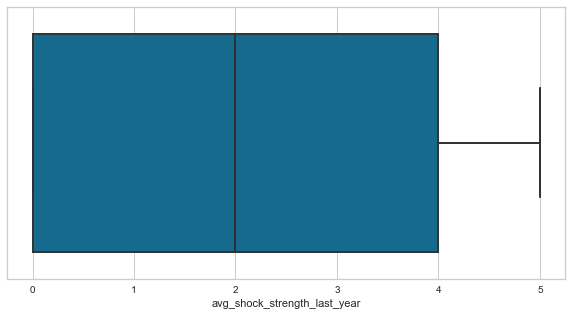

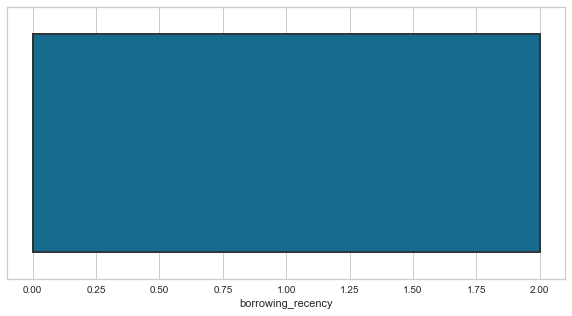

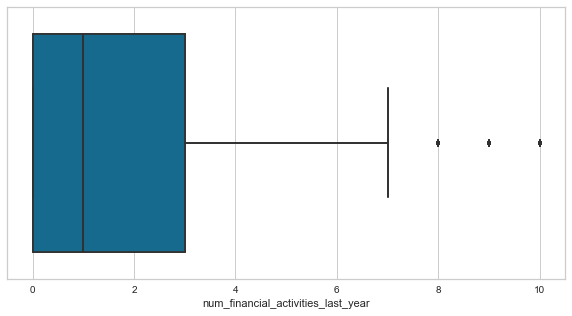

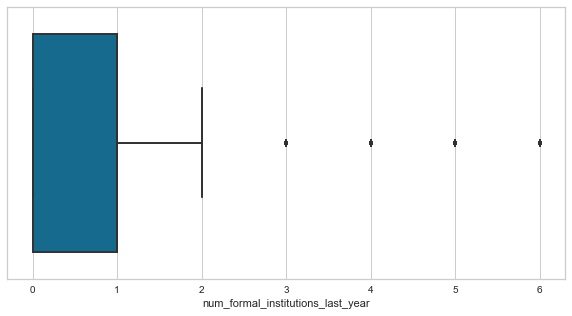

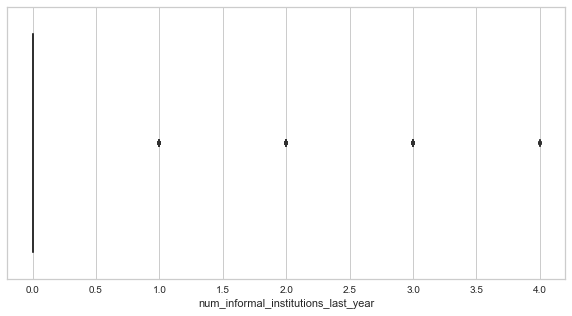

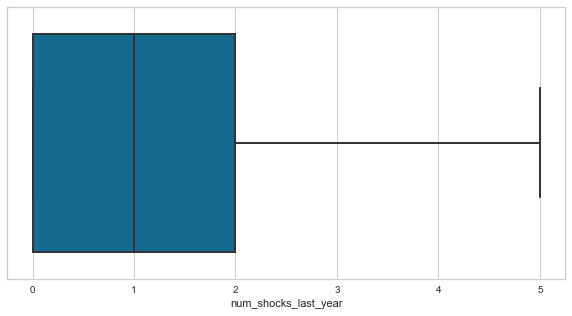

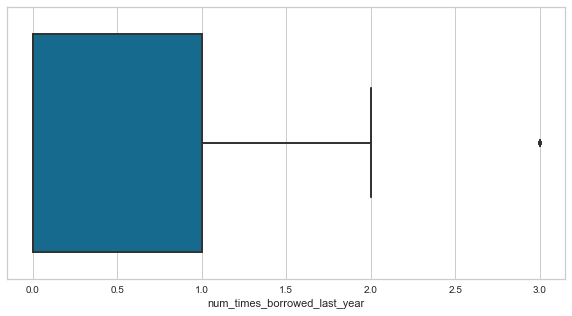

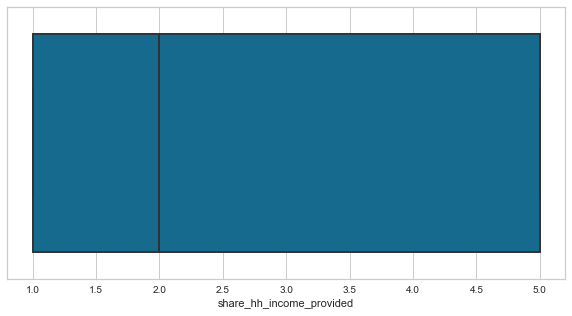

In [188]:
boxplot(data['avg_shock_strength_last_year'])
boxplot(data['borrowing_recency'])
boxplot(data['num_financial_activities_last_year'])
boxplot(data['num_formal_institutions_last_year'])
boxplot(data['num_informal_institutions_last_year'])
boxplot(data['num_shocks_last_year'])
boxplot(data['num_times_borrowed_last_year'])
boxplot(data['share_hh_income_provided'])

__Im not feeling like the outliers in the remaining columns have the potential to corrupt the data to the point of needing to be removed, some of these just look like higher scores that are completely reasonable, so I don't think removing them is necessary__

# Feature Engineering

__Here I want to begin with looking at features to create within the education features__

In [384]:
#I am going to add together all of the "can" and "literacy" features to get a total score of ability
ed_mapper = {'False':0, 'True':1}
data['literacy'] = data['literacy'].astype(str)
data['literacy'].replace(ed_mapper, inplace = True)

data['can_add'] = data['can_add'].astype(str)
data['can_add'].replace(ed_mapper, inplace = True)

data['can_divide'] = data['can_divide'].astype(str)
data['can_divide'].replace(ed_mapper, inplace = True)

data['can_calc_percents'] = data['can_calc_percents'].astype(str)
data['can_calc_percents'].replace(ed_mapper, inplace=True)

data['can_calc_compounding'] = data['can_calc_compounding'].astype(str)
data['can_calc_compounding'].replace(ed_mapper, inplace=True)

data['education_skills'] = data['literacy'] + data['can_add'] + data['can_divide'] + data['can_calc_percents'] + data['can_calc_compounding']

In [385]:
data['education_skills'].corr(data['poverty_probability'])

-0.1482085220982802

In [386]:
#see if we can multiply our education level by the education skills category to get overall intelligence level?
data['overall_cognitive_ability'] = data['education_skills'] * data['education_level']
data['overall_cognitive_ability'].corr(data['poverty_probability'])

-0.32458877641978484

__Now I want to look at phone use, aggregating can_call, can_text, can_use_internet, can_make_transaction, and advanced_phone_use in order to create an overall phone use score__

In [387]:
phone_mapper = {'False':0, 'True':1}
data['can_call'] = data['can_call'].astype(str)
data['can_call'].replace(ed_mapper, inplace = True)

data['can_text'] = data['can_text'].astype(str)
data['can_text'].replace(ed_mapper, inplace = True)

data['can_use_internet'] = data['can_use_internet'].astype(str)
data['can_use_internet'].replace(ed_mapper, inplace = True)

data['can_make_transaction'] = data['can_make_transaction'].astype(str)
data['can_make_transaction'].replace(ed_mapper, inplace = True)

data['advanced_phone_use'] = data['advanced_phone_use'].astype(str)
data['advanced_phone_use'].replace(ed_mapper, inplace = True)

data['phone_mastery'] = data['can_call'] + data['can_text'] + data['can_use_internet'] + data['can_make_transaction'] + data['advanced_phone_use']

In [388]:
data['phone_mastery'].corr(data['poverty_probability'])

-0.3259176409690434

__Now I am going to look at borrowing information about each person__

In [389]:
#I want to look for relationships between the amount that someone is borrowing and the amount of income that the individual provides for their household
data['borrowed/share_hh_income'] = data['num_times_borrowed_last_year'] / data['share_hh_income_provided']
data['borrowed/share_hh_income'].corr(data['poverty_probability'])

0.05221655341548681

In [390]:
#looking at number of financial shocks experienced and shock strength
data['financial_shock_magnitude'] = data['num_shocks_last_year']*data['avg_shock_strength_last_year']
data['financial_shock_magnitude'].corr(data['poverty_probability'])

0.12892234419786913

In [391]:
#adding together interest rates to get a picture of a total interest rate if a person has more than one loan
data['total_current_interest'] = data['bank_interest_rate'] + data['mfi_interest_rate'] + data['other_fsp_interest_rate'] + data['mm_interest_rate']
data['total_current_interest'].corr(data['poverty_probability'])

-0.02621034519935234

__-------------NOTE: The model scores better on the training set without the two features below-------------__

__I wonder if age and education level have any hidden relationship?__
- interestingly, the model scores better with this left out even though it is reasonable correlated witht the target

In [364]:
# data['education_level_age'] = data['education_level']/data['age']
# data['education_level_age'].corr(data['poverty_probability'])

-0.3272146717945736

__Get an aggregated savings feature__

In [354]:
# savings_mapper = {'False':0, 'True':1}
# data['formal_savings'] = data['formal_savings'].astype(str)
# data['formal_savings'].replace(savings_mapper, inplace = True)

# data['informal_savings'] = data['informal_savings'].astype(str)
# data['informal_savings'].replace(savings_mapper, inplace = True)

# data['cash_property_savings'] = data['cash_property_savings'].astype(str)
# data['cash_property_savings'].replace(savings_mapper, inplace = True)

# data['total_savings'] = data['formal_savings'] + data['informal_savings'] + data['cash_property_savings']
# data['total_savings'].corr(data['poverty_probability'])

-0.19605187685595948

# Numeric Feature Tranformations
- I am going to transform numeric features to have a more normal distribution if possible, but as I am increasingly becoming aware of, using log transformations or box cox transformations are impossible on data a lot of the time that is 0 or 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E43BBC60F0>,
      dtype=object)

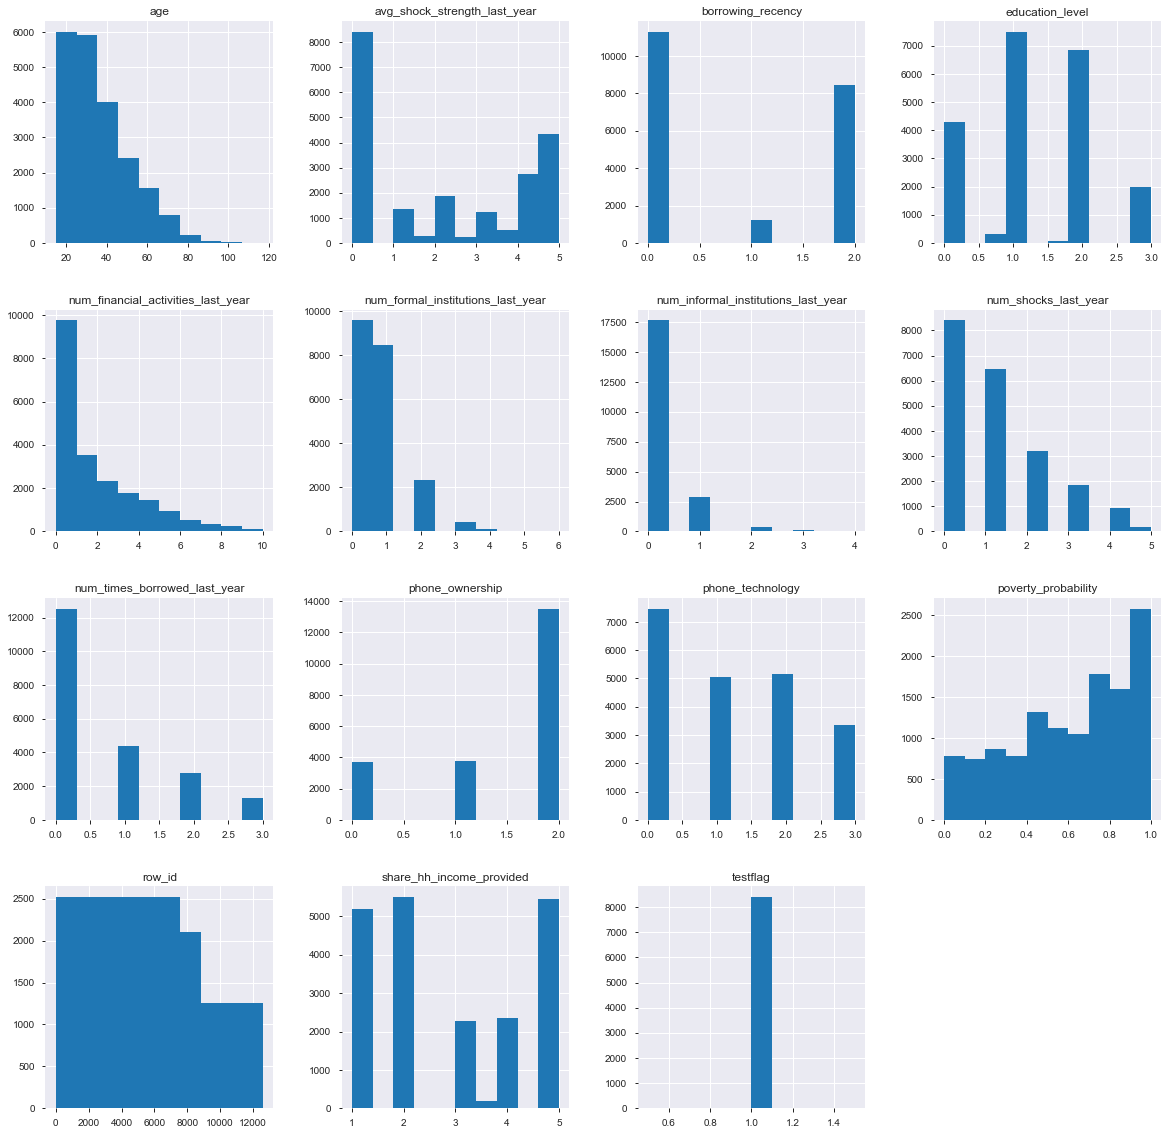

In [226]:
num_data = data.select_dtypes(include = ['float64', 'int64'])
num_data.hist(figsize = (20, 20))

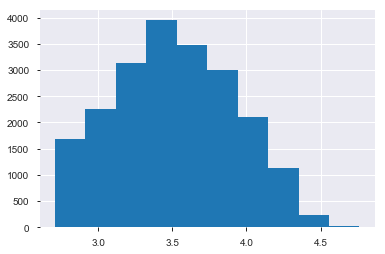

In [227]:
np.log(data['age']).hist()

In [343]:
data['age'] = np.log(data['age'])

# Feature Selection
- Interesting note, this greatly reduced the quality of the predictions, so I have left this in here to refer back to later on, but only as a future resource, and to be able to look at feature importances in a different way to make the black box models more interpretable, like feature_importances_

In [14]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

__Gotta run the modeling code first before this__

In [72]:
## Define the variance threhold and fit the threshold to the feature array. 
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Features_reduced = sel.fit_transform(train_data.select_dtypes(exclude = ['object']))

## Print the support and shape for the transformed features
print(sel.get_support())
print(Features_reduced.shape)

[ True False False  True  True  True  True False  True False  True False
  True  True  True False  True  True  True  True  True  True  True  True
  True False  True  True  True False  True False False False  True  True
  True False  True  True  True  True  True  True  True  True False  True
  True  True False]
(12600, 37)


In [82]:
## Reshape the Label array
labels = np.array(labels)
Labels = labels.reshape(labels.shape[0],)

## Set folds for nested cross validation
nr.seed(988)
feature_folds = ms.KFold(n_splits=5, shuffle = True)

## Perform feature selection by CV with high variance features only
nr.seed(6677)
selector = fs.RFECV(estimator = rf, cv = feature_folds,
                      scoring = 'r2')
selector = selector.fit(Features_reduced, Labels)
selector.support_ 

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [83]:
selector.ranking_

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [84]:
Features_reduced = selector.transform(Features_reduced)
Features_reduced.shape

(12600, 36)

Text(0.5, 1.0, 'Mean AUC by number of features')

Text(0, 0.5, 'AUC')

Text(0.5, 0, 'Number of features')

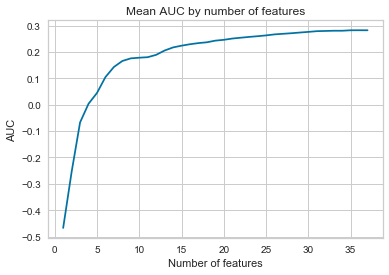

In [85]:
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.title('Mean AUC by number of features')
plt.ylabel('AUC')
plt.xlabel('Number of features')

In [95]:
Features_reduced = pd.DataFrame(Features_reduced)

# Modeling

In [314]:
#modeling packages for data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
import lightgbm as lgb

#visualize residuals
from yellowbrick.regressor import ResidualsPlot

In [392]:
#dropping nominal row id feature, its completely unnecessary
data.drop('row_id', axis = 1, inplace = True)

In [393]:
#dummy code our data
data_dummies = pd.get_dummies(data)

#split train and test
train_data = data_dummies[data_dummies['testflag'] != 1]
test_data = data_dummies[data_dummies['testflag'] == 1]

# train_data = data[data['testflag'] != 1]
# test_data = data[data['testflag'] == 1]

#drop target from test
test_data.drop('poverty_probability', axis=1, inplace=True)

#drop testflag from data
test_data.drop('testflag', axis=1, inplace=True)
train_data.drop('testflag', axis=1, inplace=True)

C:\Users\Sam Cannon\Python\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [394]:
#specify our features and target

features = train_data.drop('poverty_probability', axis = 1)
labels = train_data['poverty_probability']

# #Label Encoding
# for x in features.columns[features.dtypes == 'object']:
#     features[x] = features[x].factorize()[0]

#scale features (if this changes our outcome, which it really doesn't)
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

#split training data into train and test set for validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .3, random_state = 45)

#scoring function for regression
def get_score(model):
        '''
        Fits the model and returns a series containing the RMSE, MAE, and R^2
        '''
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        import time

        startTime = time.time()  # Getting training time
        
        # Fits with training set
        model.fit(X_train, y_train)
        totalTime = time.time() - startTime
        predictions = model.predict(X_test)
        
        r2 = model.score(X_test, y_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
            
        score_results = pd.Series([r2, rmse, mae, totalTime], index=['R^2', 'RMSE', 'MAE', 'TrainingTime(sec)'])
        
        return score_results

# Linear Regression

In [395]:
lm = LinearRegression()
lmScore = get_score(lm)
lmScore

R^2                 0.36
RMSE                0.24
MAE                 0.19
TrainingTime(sec)   0.09
dtype: float64

ResidualsPlot(alpha=0.75,
       ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000014F0B0264E0>,
       hist=True, line_color=None, model=None, test_color=None,
       train_color=None)

0.35670673986546464

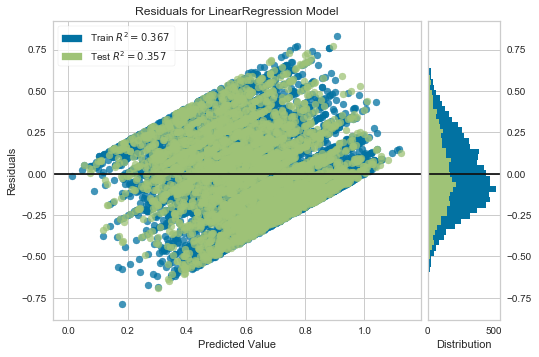

In [396]:
visualizer = ResidualsPlot(lm)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

# Gradient Boosting

In [397]:
gbt = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=1)
gbtScore = get_score(gbt)
gbtScore

R^2                  0.41
RMSE                 0.23
MAE                  0.18
TrainingTime(sec)   17.27
dtype: float64

ResidualsPlot(alpha=0.75,
       ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001FE20EB1940>,
       hist=True, line_color=None, model=None, test_color=None,
       train_color=None)

0.41211933117099897

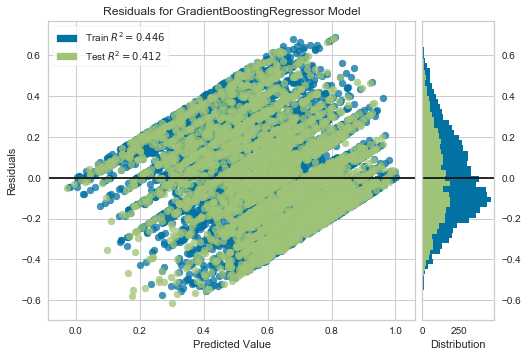

In [20]:
visualizer = ResidualsPlot(gbt)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

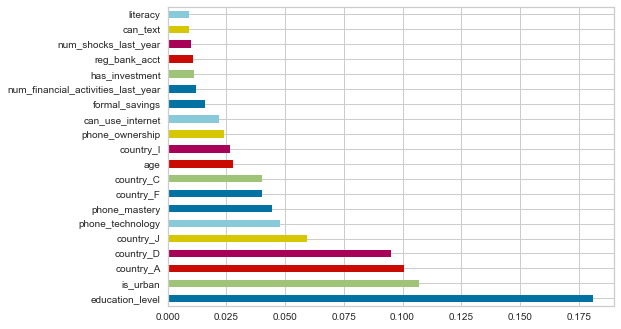

In [214]:
feature_importances = pd.Series(gbt.feature_importances_, index=features.columns)
feature_importances.nlargest(20).plot(kind='barh')

# LightGBM

In [398]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
mlgbScore = get_score(model_lgb)
mlgbScore

R^2                 0.43
RMSE                0.22
MAE                 0.18
TrainingTime(sec)   1.00
dtype: float64

ResidualsPlot(alpha=0.75,
       ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000014F0B08CC18>,
       hist=True, line_color=None, model=None, test_color=None,
       train_color=None)

0.4312630306470991

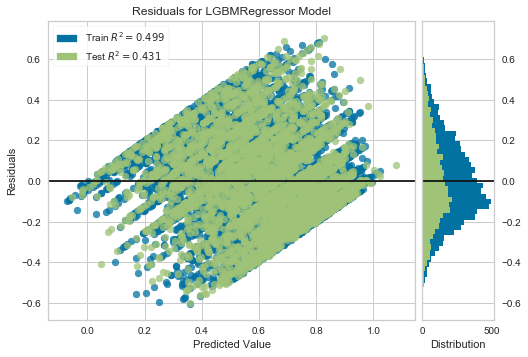

In [286]:
visualizer = ResidualsPlot(model_lgb)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

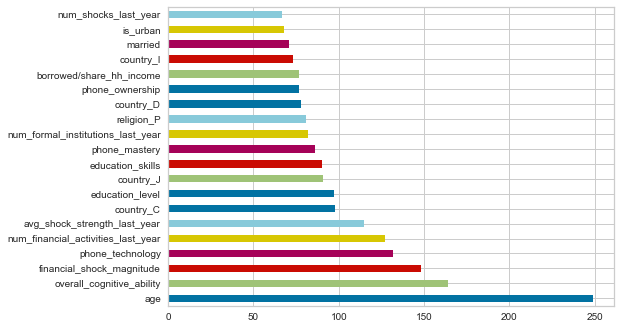

In [281]:
feature_importances = pd.Series(model_lgb.feature_importances_, index=features.columns)
feature_importances.nlargest(20).plot(kind='barh')

# Random Forest

In [399]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=2)
rfScore = get_score(rf)
rfScore

R^2                  0.42
RMSE                 0.22
MAE                  0.18
TrainingTime(sec)   30.29
dtype: float64

ResidualsPlot(alpha=0.75,
       ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000014F0C3D9518>,
       hist=True, line_color=None, model=None, test_color=None,
       train_color=None)

0.4158363788611807

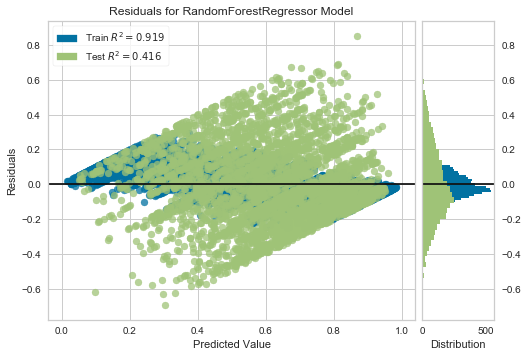

In [287]:
visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

__Interesting to see the differences between feature importances in GradientBoosting, LightGBM, and RandomForest__

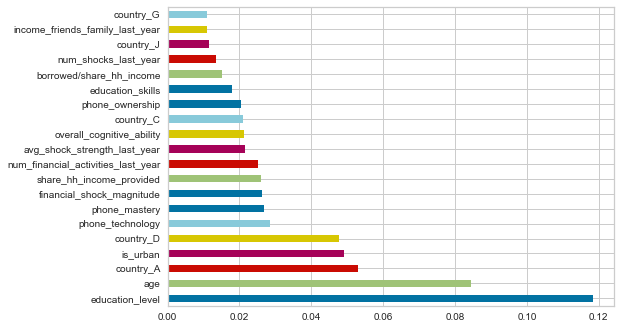

In [283]:
feature_importances = pd.Series(rf.feature_importances_, index=features.columns)
feature_importances.nlargest(20).plot(kind='barh')

# XGBoost

In [400]:
import xgboost as xgb
xgb = xgb.XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3)
get_score(xgb)

R^2                 0.41
RMSE                0.23
MAE                 0.18
TrainingTime(sec)   1.41
dtype: float64

# Ensembling and Stacking Models
- http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

In [423]:
stacked_pred = ((rf.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test)
               + rf.predict(X_test) + xgb.predict(X_test) + gbt.predict(X_test) + model_lgb.predict(X_test) + rf.predict(X_test) 
                + model_lgb.predict(X_test) + rf.predict(X_test) + rf.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test)
                + rf.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test) + rf.predict(X_test) + model_lgb.predict(X_test)
                + rf.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test) + rf.predict(X_test)
                + model_lgb.predict(X_test) + model_lgb.predict(X_test) + rf.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test))/30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
r2_score(y_test, stacked_pred)
mean_absolute_error(y_test, stacked_pred)
np.sqrt(mean_squared_error(y_test, stacked_pred))

0.4393036419030891

0.17778131102664652

0.21991566198429502

In [405]:
submissions_pred = (rf.predict(test_data) + model_lgb.predict(test_data) + model_lgb.predict(test_data) + model_lgb.predict(test_data) + model_lgb.predict(test_data)
                    + rf.predict(test_data) + xgb.predict(test_data) + gbt.predict(test_data) + model_lgb.predict(test_data) + rf.predict(test_data)
                    + model_lgb.predict(test_data) + rf.predict(test_data) + rf.predict(test_data) + model_lgb.predict(test_data) + model_lgb.predict(test_data)
                   + rf.predict(test_data) + model_lgb.predict(test_data) + model_lgb.predict(test_data) + rf.predict(test_data) + model_lgb.predict(test_data)
                   + rf.predict(test_data) + model_lgb.predict(test_data) + model_lgb.predict(X_test) + model_lgb.predict(test_data) + rf.predict(test_data)
                   + model_lgb.predict(test_data) + model_lgb.predict(test_data) + rf.predict(test_data) + model_lgb.predict(test_data))/29
ensemble_df = pd.DataFrame(submissions_pred)
ensemble_df.to_csv('ensemble_scores.csv')                   

# Nested Cross-Validation
- Thought I would include this code so that I could use it for future models potentially, I would use nested cross validation for a model that is being used in production, but in terms of competition score, this only reduced the R2

In [182]:
import numpy.random as nr
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as model_selection
# this defines the inner cross-validation
nr.seed(123)
inside = model_selection.KFold(n_splits=10, shuffle = True)

#this defines outer cross-validation
nr.seed(321)
outside = model_selection.KFold(n_splits=10, shuffle = True)


## Define the dictionary for the grid search and the model object to search on
param_grid = {"max_features": list(range(1, 80, 1)), "min_samples_leaf":list(range(1, 20, 2))}

## Perform the grid search over the parameters
nr.seed(4455)
tuned_rf = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'r2',
                      return_train_score = True)

tuned_rf.fit(features, labels)
print(tuned_rf.best_estimator_.max_features)
print(tuned_rf.best_estimator_.min_samples_leaf)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=2, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], 'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
 

36
1


In [184]:
nr.seed(498)
cv_estimate = model_selection.cross_val_score(tuned_rf, features, labels, 
                                 cv = outside) # Use the outside folds

print('Mean R^2 = %4.3f' % np.mean(cv_estimate))
print('SDT of R^2       = %4.3f' % np.std(cv_estimate))
print('R^2 by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean R^2 = 0.427
SDT of R^2       = 0.018
R^2 by cv fold
Fold  1    0.417
Fold  2    0.435
Fold  3    0.447
Fold  4    0.426
Fold  5    0.431
Fold  6    0.408
Fold  7    0.412
Fold  8    0.423
Fold  9    0.466
Fold 10    0.401


In [189]:
#create final cross validation fold for best parameters
#this defines outer cross-validation
nr.seed(4567)
final = model_selection.KFold(n_splits=10, shuffle = True)

nr.seed(1115)
rf_best_params = RandomForestRegressor( 
                                max_features = tuned_rf.best_estimator_.max_features, 
                                min_samples_leaf = tuned_rf.best_estimator_.min_samples_leaf) 
rf_best_params.fit(features, labels)

final_cv_estimate = model_selection.cross_val_score(rf_best_params, features, labels, cv = final) # Use the final folds

print('Mean R^2 = %4.3f' % np.mean(final_cv_estimate))
print('SDT of R^2       = %4.3f' % np.std(final_cv_estimate))
print('R^2 by cv fold')
for i, x in enumerate(final_cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=36, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

Mean R^2 = 0.365
SDT of R^2       = 0.034
R^2 by cv fold
Fold  1    0.391
Fold  2    0.383
Fold  3    0.351
Fold  4    0.437
Fold  5    0.307
Fold  6    0.334
Fold  7    0.354
Fold  8    0.361
Fold  9    0.347
Fold 10    0.387


Gotta label encode our test set before predicting

# Vecstack

In [24]:
from vecstack import stacking
from sklearn.metrics import r2_score as r2
models = [rf, xgb, model_lgb, gbt]

S_train, S_test = stacking(models, X_train, y_train, test_data, regression=True, mode='oof_pred_bag', needs_proba=False, metric = r2, save_dir=None, n_folds=4, 
                           stratified=True, shuffle=True, random_state=0,  verbose=2)



C:\Users\Sam Cannon\Python\lib\site-packages\vecstack\core.py:459: UserWarning:

This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>



task:         [regression]
metric:       [r2_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [RandomForestRegressor]
    fold  0:  [0.41200130]
    fold  1:  [0.38028801]
    fold  2:  [0.38281754]
    fold  3:  [0.42246303]
    ----
    MEAN:     [0.39939247] + [0.01824104]
    FULL:     [0.39971954]

model  1:     [XGBRegressor]
    fold  0:  [0.42138795]
    fold  1:  [0.38657615]
    fold  2:  [0.39250303]
    fold  3:  [0.41342310]
    ----
    MEAN:     [0.40347256] + [0.01436832]
    FULL:     [0.40388913]

model  2:     [LGBMRegressor]
    fold  0:  [0.43802818]
    fold  1:  [0.40792669]
    fold  2:  [0.41300624]
    fold  3:  [0.43266431]
    ----
    MEAN:     [0.42290636] + [0.01271112]
    FULL:     [0.42330912]

model  3:     [GradientBoostingRegressor]
    fold  0:  [0.42280531]
    fold  1:  [0.38739516]
    fold  2:  [0.39353703]
    fold  3:  [0.41164752]
    ----
    MEAN:     [0.40384625] + [0.01411758]
    FULL:     [0.40427810]



In [25]:
model = model_lgb
    
model = model.fit(S_train, y_train)
stack_pred = model.predict(S_test)
stack_pred = pd.DataFrame(stack_pred)
stack_pred.to_csv('stacked_predictions.csv')
# print('Final prediction score: [%.8f]' % r2(y_test, y_pred))

In [23]:
from mlxtend.regressor import StackingRegressor
from mlxtend.data import boston_housing_data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.simplefilter('ignore')

stregr = StackingRegressor(regressors=[model_lgb, model_lgb, model_lgb, model_lgb, rf, gbt, model_lgb, model_lgb], 
                           meta_regressor=model_lgb)

# Training the stacking regressor

stregr.fit(X_train, y_train)
stregr.score(X_test, y_test)

StackingRegressor(meta_regressor=LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2319, feature_fraction_seed=9,
       importance_type='split', learning_rate=0.05, max_bin=55,
       max_depth=-1, min_c...=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
         refit=True,
         regressors=[LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2319, feature_fraction_seed=9,
       importance_type='split', learning_rate=0.05, max_bin=55,
       max_depth=-1, min_chil...0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

0.3789851937255745